# Twitter Sentiment Classification using Vowpal Wabbit in MMLSpark

In this example, we show how to build a sentiment classification model using Vowpal Wabbit (VW) in MMLSpark. The data set we use to train and evaluate the model is [Sentiment140](http://help.sentiment140.com/for-students/?source=post_page---------------------------) twitter data. First, we import a few packages that we need.

In [ ]:
import os
import re
import urllib.request
import numpy as np
import pandas as pd
from zipfile import ZipFile
from bs4 import BeautifulSoup
from pyspark.sql.functions import udf, rand, when, col
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, RegexTokenizer
from mmlspark.vw import VowpalWabbitClassifier
from mmlspark.train import ComputeModelStatistics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# URL to download the sentiment140 dataset and data file names
DATA_URL = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
TRAIN_FILENAME = "training.1600000.processed.noemoticon.csv"
TEST_FILENAME = "testdata.manual.2009.06.14.csv"
# Folder for storing the downloaded data
DATA_FOLDER = "data"

## Data Preparation

We use [Sentiment140](http://help.sentiment140.com/for-students/?source=post_page---------------------------) twitter data which originated from a Standford research project to train and evaluate VW classification model on Spark. The same dataset has been used in a previous [Azure Machine Learning sample](https://github.com/Azure-Samples/MachineLearningSamples-TwitterSentimentPrediction) on twitter sentiment prediction. Before using the data to build the classification model, we first download and clean up the data.

In [ ]:
data_dir = "/dbfs/" + DATA_FOLDER
if not os.path.exists(data_dir): 
  os.makedirs(data_dir)

In [ ]:
def download_data(url, data_folder=DATA_FOLDER, filename="downloaded_data.zip"):
    """Download and extract data from url"""
    
    data_dir = "/dbfs/" + DATA_FOLDER
    if not os.path.exists(data_dir): os.makedirs(data_dir)
    downloaded_filepath = os.path.join(data_dir, filename)
    print("Downloading data...")
    urllib.request.urlretrieve(url, downloaded_filepath)
    print("Extracting data...")
    zipfile = ZipFile(downloaded_filepath)
    zipfile.extractall(data_dir)
    zipfile.close()
    print("Finished data downloading and extraction.")
    
download_data(DATA_URL)

Let's read the training data into a Spark DataFrame.

In [ ]:
schema = StructType([
    StructField('label', DoubleType(), True),
    StructField('id', StringType(), True),
    StructField('date', StringType(), True), 
    StructField('query_string', StringType(), True),
    StructField('user', StringType(), True),
    StructField('text', StringType(), True)])

df_train = spark.read.format('csv').schema(schema).load(os.path.join("dbfs:", DATA_FOLDER, TRAIN_FILENAME))

We can take a look at the training data and check how many samples it has. We should see that there are 1.6 million samples in the training data. There are 6 fields in the training data:
* label: the sentiment of the tweet (0.0 = negative, 2.0 = neutral, 4.0 = positive)
* id: the id of the tweet
* date: the date of the tweet
* query_string: The query used to extract the data. If there is no query, then this value is NO_QUERY.
* user: the user that tweeted
* text: the text of the tweet

In [ ]:
df_train.limit(10).toPandas()

In [ ]:
print("Number of training samples: ", df_train.count())

Before training the model, we randomly permute the data to mix negative and positive samples. This is helpful for properly training online learning algorithms like VW.

In [ ]:
df_train = df_train.orderBy(rand()) \
                   .withColumn("label", when(col("label") > 0, 1.0).otherwise(0.0)) \
                   .select(["label", "text"])

## VW MMLSpark Training

Now we are ready to define a pipeline which consists of feture engineering steps and the VW model.

In [ ]:
# Specify featurizers
tokenizer = RegexTokenizer(inputCol="text",
                           outputCol="words")

count_vectorizer = CountVectorizer(inputCol="words",
                                   outputCol="features")

# Define VW classification model
args = "--loss_function=logistic --quiet --holdout_off"
vw_model = VowpalWabbitClassifier(featuresCol="features", 
                                  labelCol="label", 
                                  args=args, 
                                  numPasses=10)

# Create a pipeline
vw_pipeline = Pipeline(stages=[tokenizer, count_vectorizer, vw_model])

With the prepared training data, we can fit the model pipeline as follows.

In [ ]:
vw_trained = vw_pipeline.fit(df_train)

## Model Performance Evaluation

After training the model, we evaluate the performance of the model using the test set which is manually labeled.

In [ ]:
df_test = spark.read.format("csv").schema(schema).load(os.path.join("dbfs:/", DATA_FOLDER, TEST_FILENAME))

We only use positive and negative tweets in the test set to evaluate the model, since our model is a binary classification model trained with only positive and negative tweets.

In [ ]:
print("Number of test samples before filtering: ", df_test.count())
df_test = df_test.filter(col("label") != 2.0) \
                 .withColumn("label", when(col("label") > 0, 1.0).otherwise(0.0)) \
                 .select(["label", "text"])
print("Number of test samples after filtering: ", df_test.count())

In [ ]:
# Make predictions
predictions = vw_trained.transform(df_test)
predictions.limit(10).toPandas()

In [23]:
# Compute model performance metrics
metrics = ComputeModelStatistics(evaluationMetric="classification", 
                                 labelCol="label", 
                                 scoredLabelsCol="prediction").transform(predictions)
metrics.toPandas()

,evaluation_type,confusion_matrix,accuracy,precision,recall,AUC
0,Classification,"DenseMatrix([[ 133., 44.],\n [ ...",0.805014,0.78,0.857143,0.804278


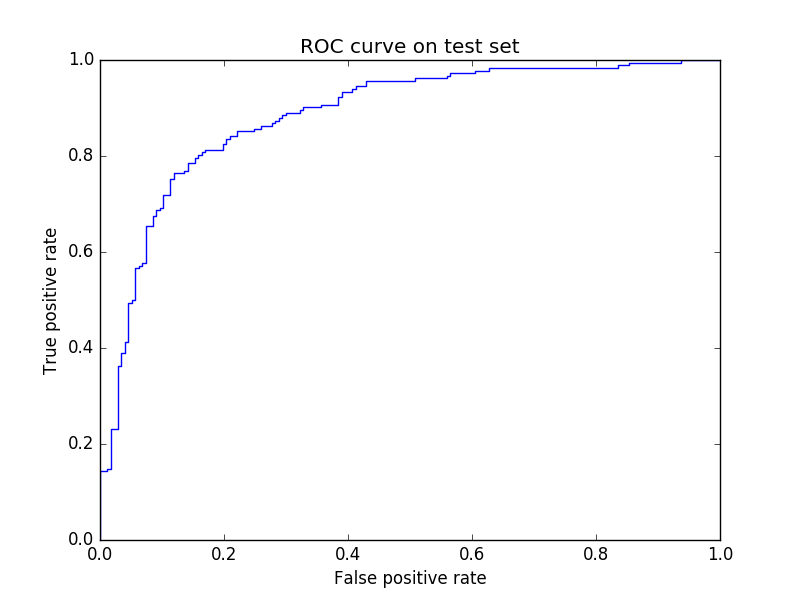

In [24]:
# Utility class for plotting ROC curve (https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve)
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

preds = predictions.select("label", "probability") \
                   .rdd.map(lambda row: (float(row["probability"][1]), float(row["label"])))
roc_points = CurveMetrics(preds).get_curve("roc")

# Plot ROC curve
fig = plt.figure()
x_val = [x[0] for x in roc_points]
y_val = [x[1] for x in roc_points]
plt.title("ROC curve on test set")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(x_val, y_val)
# Use display() if you're on Azure Databricks or you can do fig.show()
display(fig)